In [2]:
import overpy 
import geopandas as gpd
import geojson
import matplotlib.pyplot as plt
import requests
import osm2geojson
import pybdshadow
import pandas as pd
import shapely

from firebase_functions import firestore_fn, https_fn
import google.cloud.firestore

In [3]:
#lat = 51.531028
#long = -0.095722
lat = 51.52420006595694
long = -0.15105286635513696
south, west, north, east = (lat - 0.0045), (long - 0.0045), (lat + 0.0045), (long + 0.0045)

# fetch all ways and nodes
overpass_url = "http://overpass-api.de/api/interpreter"
query = f"""
    [out:json];
    (
    way({south}, {west}, {north}, {east}) ["leisure"="park"];
    way({south}, {west}, {north}, {east}) ["building"];
    );
    (._;>;);
    out geom;
    """

response = requests.get(overpass_url, params={'data': query})
if response.status_code == 200:
    # convert result to GeoDataFrame
    data = response.json()
    geojson = osm2geojson.json2geojson(data)
    geojsonDF = gpd.GeoDataFrame.from_features(geojson)

https://overpass-turbo.eu/s/1HVm

In [8]:
south, west, north, east

(51.51970006595694,
 -0.15555286635513696,
 51.52870006595694,
 -0.14655286635513695)

In [12]:
temp = geojsonDF.tags.apply(pd.Series)
'building:levels' in temp.columns

True

In [13]:
temp.shape[0]

(4416, 145)

In [5]:
levels = temp['building:levels'].fillna(1)

if 'height' in temp.columns:
        approx_ht = temp.height.fillna(round(levels.astype(int) * 128/36))
else:
    approx_ht = round(levels.astype(int) * 128/36)

AttributeError: 'DataFrame' object has no attribute 'height'

In [21]:
geojsonDF['height'] = approx_ht.astype(int)
geojsonDF['leisure'] = temp.leisure

In [22]:
geojsonDF.loc[geojsonDF['leisure'] == 'park', 'height'] = 0
parks = geojsonDF.loc[geojsonDF['leisure'] == 'park']
mass = geojsonDF.loc[geojsonDF['leisure'] != 'park']
parks

,geometry,type,id,tags,nodes,height,leisure
3802,"POLYGON ((-0.09298 51.53606, -0.09221 51.53535...",way,34065881,"{'dog': 'no', 'leisure': 'park', 'name': 'Arli...","[5263395269, 5263395271, 5263395270, 390363330...",0,park
3803,"POLYGON ((-0.09706 51.53553, -0.09697 51.53545...",way,34082365,{'leisure': 'park'},"[390556641, 390556642, 390556645, 4737384212, ...",0,park
3853,"POLYGON ((-0.09825 51.52798, -0.09813 51.52770...",way,34083497,"{'leisure': 'park', 'name': 'King Square Garde...","[390570285, 885680330, 885680369, 390570286, 8...",0,park
3872,"POLYGON ((-0.09472 51.53242, -0.09373 51.53273...",way,39658932,"{'dog': 'leashed', 'leisure': 'park', 'name': ...","[475413372, 475413374, 8386357250, 8386357249,...",0,park
3928,"POLYGON ((-0.09874 51.53196, -0.09878 51.53199...",way,67384696,"{'leisure': 'park', 'name': 'Graham Street Par...","[674209659, 560505142, 674209663, 813784736, 8...",0,park
4199,"POLYGON ((-0.09517 51.53605, -0.09500 51.53612...",way,163735245,"{'leisure': 'park', 'name': 'Union Square'}","[1754132859, 1754132935, 8751314728, 499290644...",0,park
4255,"POLYGON ((-0.09176 51.53261, -0.09106 51.53281...",way,231867400,"{'leisure': 'park', 'name': 'Community Garden'}","[2401927297, 2401927298, 2401927299, 240192730...",0,park
4276,"POLYGON ((-0.09494 51.53489, -0.09487 51.53483...",way,452901711,"{'leisure': 'park', 'name': 'Canalside Square'}","[4497135620, 8420997289, 5186209786, 518620978...",0,park
4301,"POLYGON ((-0.09592 51.53553, -0.09579 51.53558...",way,475555011,"{'leisure': 'park', 'name': 'Packington Square'}","[4692951600, 8840505444, 8875047053, 469295160...",0,park
4303,"POLYGON ((-0.10099 51.52930, -0.10085 51.52926...",way,477378856,"{'leisure': 'park', 'operator': 'Islington Cou...","[1623696388, 1623696387, 1623696386, 162369638...",0,park


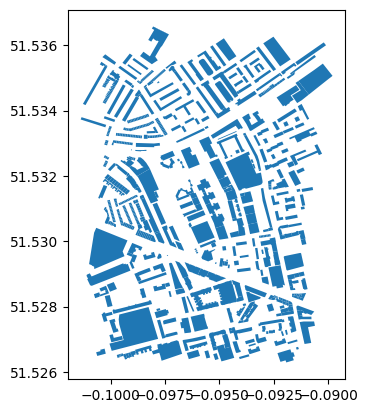

In [23]:
geojsonDF.plot(markersize=0)
plt.gca().set_aspect(1.5)
plt.show()

In [24]:
buildings = pybdshadow.bd_preprocess(mass)

C:\Python311\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
#Given UTC time
date = pd.to_datetime('2022-01-01 12:45:33.959797119')\
    .tz_localize('Europe/London')\
    .tz_convert('UTC')
#Calculate shadows
shadows = pybdshadow.bdshadow_sunlight(buildings,date,roof=True,include_building = False)
shadows

C:\Python311\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
C:\Python311\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
C:\Python311\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
C:\Python311\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
C:\Python311

,height,building_id,geometry,type
0,4,3861,"POLYGON ((-0.09442 51.52881, -0.09442 51.52881...",roof
1,4,3871,"POLYGON ((-0.09473 51.53149, -0.09473 51.53149...",roof
2,4,3873,"POLYGON ((-0.09546 51.53242, -0.09546 51.53242...",roof
3,4,3902,"POLYGON ((-0.09272 51.53053, -0.09272 51.53053...",roof
4,4,3929,"POLYGON ((-0.09853 51.53060, -0.09853 51.53060...",roof
...,...,...,...,...
3758,0,3758,POLYGON EMPTY,ground
3759,0,3759,POLYGON EMPTY,ground
3760,0,3760,POLYGON EMPTY,ground
3761,0,3761,POLYGON EMPTY,ground


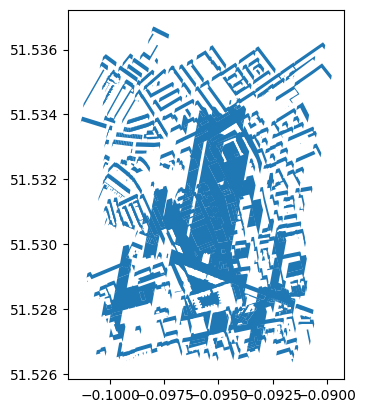

In [26]:
shadows.plot(markersize=0)
plt.gca().set_aspect(1.5)
plt.show()

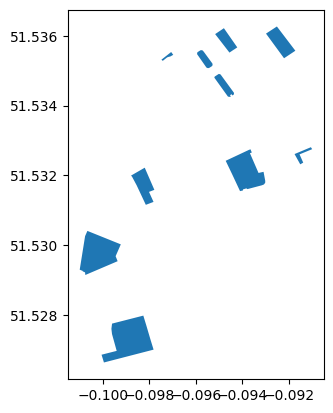

In [27]:
parks.plot(markersize=0)
plt.gca().set_aspect(1.5)
plt.show()

In [28]:
shadows_all = shadows.geometry.unary_union

In [29]:
parks_unshaded  = parks.geometry.difference(shadows_all)

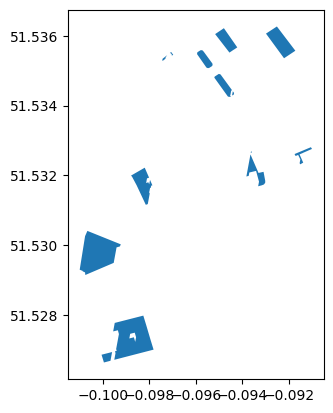

In [30]:
parks_unshaded.plot(markersize=0)
plt.gca().set_aspect(1.5)
plt.show()

In [31]:
parks_unshaded

3802    POLYGON ((-0.09252 51.53626, -0.09172 51.53557...
3803    MULTIPOLYGON (((-0.09697 51.53545, -0.09703 51...
3853    MULTIPOLYGON (((-0.09813 51.52770, -0.09795 51...
3872    MULTIPOLYGON (((-0.09359 51.53266, -0.09364 51...
3928    POLYGON ((-0.09878 51.53199, -0.09819 51.53222...
4199    POLYGON ((-0.09500 51.53612, -0.09495 51.53614...
4255    POLYGON ((-0.09106 51.53281, -0.09101 51.53276...
4276    MULTIPOLYGON (((-0.09487 51.53483, -0.09444 51...
4301    POLYGON ((-0.09579 51.53558, -0.09575 51.53558...
4303    POLYGON ((-0.10075 51.52915, -0.10076 51.52922...
dtype: geometry

### Sunniness percentage of each park:

In [59]:
sunny_perc = parks_unshaded.area/parks.area * 100

In [51]:
parks_tags = parks.tags.apply(pd.Series)
parks_concat = pd.concat([parks_tags.name, sunny_perc], axis=1)
top3 = parks_concat.sort_values(by=[0], ascending=False).head(3)

In [58]:
top3.iloc[1,0]

'Union Square'